# <center> Astroplan Review
    
### <center> Anika Slizewski


### 1. Astroplan Review

With astroplan, we define a point on the Earth (Observer) and a point on the sky (FixedTarget)to prep observations with. Astroplan is based on astropy, so import units, time, and coordinateclasses (plus some other functions) from astropy as well as the astroplan packages.

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, get_sun, get_body, get_moon

from astroplan import Observer, FixedTarget, time_grid_from_range, download_IERS_A, AirmassConstraint,MoonSeparationConstraint, moon_illumination, AltitudeConstraint, AtNightConstraint, is_observable,is_always_observable, months_observable, observability_table,SunSeparationConstraint
from astroplan.plots import plot_sky, plot_airmass, plot_parallactic


import warnings
warnings.simplefilter("ignore") #if you want to ignore the warnings lol


### 2. Observer

##### Update the Earth's orientation:

In [2]:
download_IERS_A()

##### Set our observing location:

In [3]:
apo=Observer.at_site('Apache Point',timezone='US/Mountain')
print(apo)

# or do it by hand with info from the APO site,

apo=Observer(longitude=-(105*u.deg+49*u.arcmin+13*u.arcsec), #West, make sure it's negative
             latitude=32*u.deg+46*u.arcmin+49*u.arcsec,
             elevation=2788*u.m, 
             name='APO',
             timezone='US/Mountain')
print(apo)


<Observer: name='Apache Point',
    location (lon, lat, el)=(-105.82000000000005 deg, 32.78000000000001 deg, 2797.9999999996007 m),
    timezone=<DstTzInfo 'US/Mountain' LMT-1 day, 17:00:00 STD>>
<Observer: name='APO',
    location (lon, lat, el)=(-105.82027777777778 deg, 32.78027777777777 deg, 2788.000000000296 m),
    timezone=<DstTzInfo 'US/Mountain' LMT-1 day, 17:00:00 STD>>


### 3. Time

In [4]:
now = Time.now()
print(now.iso,'=',now.to_datetime(timezone=apo.timezone))
print('\nand',now.jd,'=',now.mjd)
# using .to_datetime(timezone=apo.timezone) changes Time objects to APO time
# https://www.aavso.org/jd-calculator

2022-07-13 20:34:29.155 = 2022-07-13 14:34:29.155484-06:00

and 2459774.357281892 = 59773.857281892175


##### Set our observing times:

In [5]:
day = Time("2021-06-23")
observe_start = Time(apo.twilight_evening_astronomical(day, which='nearest'))
observe_end = Time(apo.twilight_morning_astronomical(day, which='nearest'))

window = [observe_start,observe_end]
lst_window = apo.local_sidereal_time(window)

print('Observing time in\nJD:',window[0],'-',window[1]) 
print('LST:',lst_window[0],'-',lst_window[1])
print('ISO:',window[0].iso,'-',window[1].iso)

print('\nTotal observing length is',(window[1]-window[0]).sec/3600, 'hours')

Observing time in
JD: 2459388.664408958 - 2459388.926611041
LST: 14h59m38.3778s - 21h18m14.666s
ISO: 2021-06-23 03:56:44.934 - 2021-06-23 10:14:19.194

Total observing length is 6.292849995195865 hours


##### Make our observing window:

In [6]:
time_resolution=0.5*u.hour
window_time_grid=time_grid_from_range(window,time_resolution=time_resolution)

##### Check sun and moon set and rise times:

In [7]:
sunset = apo.sun_set_time(day,which="nearest")
sunrise = apo.sun_rise_time(day,which="next")

print('Sun sets at:',sunset.to_datetime(timezone=apo.timezone),'\nand rises at:',sunrise.to_datetime(timezone=apo.timezone))

moonset=apo.moon_set_time(day, which="nearest")
moonrise=apo.moon_rise_time(day, which="nearest")

phase=apo.moon_phase(window)
illum=apo.moon_illumination(window)

print('\nMoon rises at:',moonrise.to_datetime(timezone=apo.timezone),'\nand sets at:',moonset.to_datetime(timezone=apo.timezone),'\nMoon illumination:',illum)

Sun sets at: 2021-06-22 20:10:17.017668-06:00 
and rises at: 2021-06-23 06:00:47.077395-06:00

Moon rises at: 2021-06-22 18:22:17.007312-06:00 
and sets at: 2021-06-23 04:36:26.355981-06:00 
Moon illumination: [0.96186583 0.97316608]


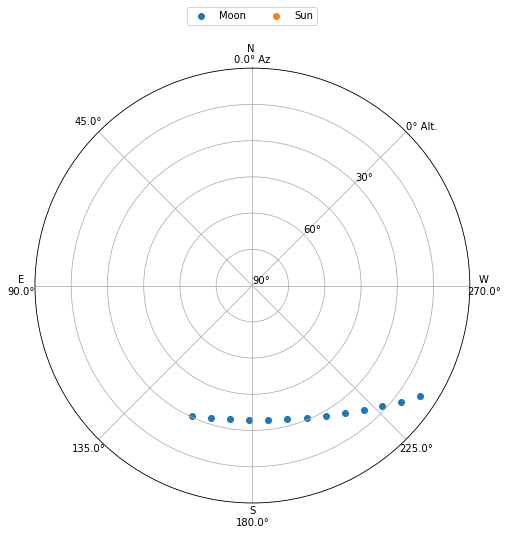

In [10]:
# Other way to check sun and moon:
sun = FixedTarget(apo.sun_altaz(window_time_grid),name='Sun')
moon = FixedTarget(apo.moon_altaz(window_time_grid),name='Moon')
plt.figure(figsize=(8,8))
plot_sky(moon,apo,window_time_grid)
plot_sky(sun,apo,window_time_grid)
plt.legend(loc='center', bbox_to_anchor=(.5,1.12),ncol=2);

### 4. Targets

Now let’s define the spot(s) on the sky we want to observe. You can do this from first making a SkyCoord object and defining the coordinates and names (you can also pull the coordinates from FITS files). 

Target objects (i.e. FixedTarget or NonFixedTarget) use SkyCoord objects and add names/metadata. We're mostly looking at distant, fixed targets.

Alternatively, SkyCoord and FixedTarget allow you to find some targets by name.

In [11]:
coords=SkyCoord(['16:10:33.6-01:02:23.21',
                '09:53:21+12:53:55',
                '12:30:04+01:09:29'],
               unit=(u.hourangle, u.deg))
print(coords[0])

<SkyCoord (ICRS): (ra, dec) in deg
    (242.64, -1.03978056)>


In [12]:
m33 = FixedTarget.from_name('M33')
m13 = FixedTarget.from_name('M13')

#OUR FAVORITE: VEGA!! 
vega = FixedTarget.from_name('Vega')

targets = [m13,m33,vega]

for c, i in zip(coords,['Spot 1','Spot 2','Spot 3']):
    t = FixedTarget(coord=c,name=i)
    targets.append(t)

print(targets[3])

<FixedTarget "Spot 1" at SkyCoord (ICRS): (ra, dec) in deg (242.64, -1.03978056)>


##### Make an airmass plot:

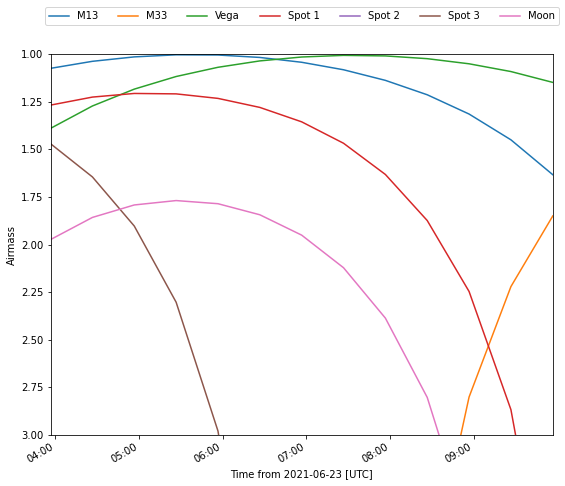

In [15]:
plt.figure(figsize=(9,7))
for target in targets:
    plot_airmass(target, apo,window_time_grid,max_airmass=3)
plot_airmass(moon,apo,window_time_grid)
plt.legend(loc='center', bbox_to_anchor=(.5,1.1),ncol=8);

##### Make a sky position plot:

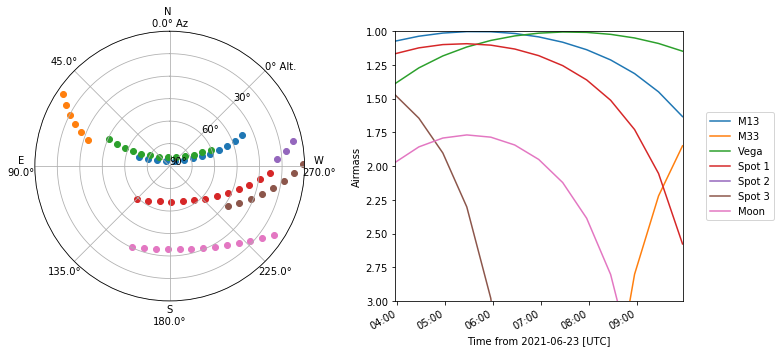

In [267]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(121, projection='polar',)
for target in targets:
    plot_sky(target, apo,window_time_grid,ax=ax)
plot_sky(moon,apo,window_time_grid,ax=ax)

a1 = fig.add_subplot(122)
for target in targets:
    plot_airmass(target, apo,window_time_grid,max_airmass=3,ax=a1)
plot_airmass(moon,apo,window_time_grid,ax=a1)
plt.legend(loc='center',bbox_to_anchor=(1.2,0.5),ncol=1)
plt.tight_layout()



##### Make a parallactic angle plot (more relevant when taking spectra):

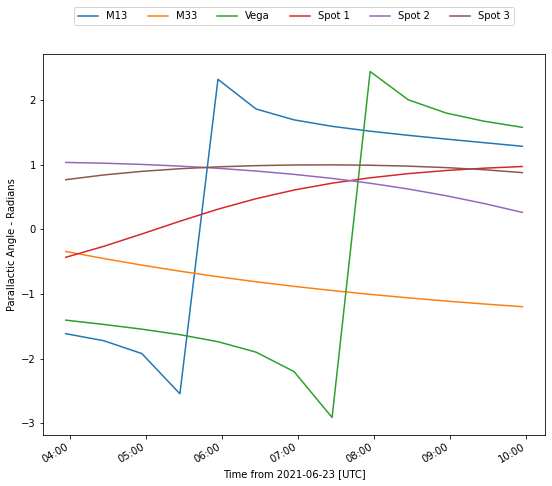

In [23]:
# This is more relevant when taking spectra
plt.figure(figsize=(9,7))
for target in targets:
    plot_parallactic(target, apo,window_time_grid)
plt.legend(loc='center', bbox_to_anchor=(.5,1.1),ncol=6);

### 5. Constraints, etc...

In [32]:
constraints = [AirmassConstraint(4),
             MoonSeparationConstraint(30*u.deg),
             AltitudeConstraint(10*u.deg,80*u.deg)]
observing_table = observability_table(constraints, apo, targets,time_range=window)

#####  Summarize our observations:

In [33]:
print(observing_table)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
        M13            True             False          0.7692307692307693
        M33            True             False          0.3076923076923077
       Vega            True             False          0.7692307692307693
     Spot 1           False             False                         0.0
     Spot 2            True             False         0.07692307692307693
     Spot 3            True             False         0.38461538461538464


#####  This is an example they do, its alright I guess:


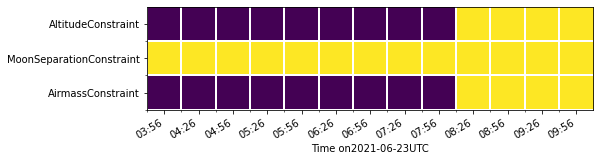

In [34]:
for target in targets[0:2]:
    observability_grid=np.zeros((len(constraints),len(window_time_grid)))
    for i, constraint in enumerate(constraints):
        observability_grid[i, :] = constraint(apo, target,times=window_time_grid)
        extent=[-0.5,-0.5+len(window_time_grid),-0.5,2.5]

fig, ax=plt.subplots()
fig.set_size_inches(8,13)
ax.imshow(observability_grid, extent=extent)
ax.set_yticks(range(0,3))
ax.set_yticklabels([c.__class__.__name__ for c in constraints])
ax.set_xticks(range(len(window_time_grid)))
ax.set_xticklabels([t.datetime.strftime("%H:%M") for t in window_time_grid])
ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.tick_params(axis='x', which='minor', bottom='off')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
ax.tick_params(axis='y', which='minor', left='off')
ax.set_xlabel('Time on{0}UTC'.format(window_time_grid[0].datetime.date()));

With astroplan you can read in big catalogs and find the best objects to observe if you have constraints, as well as find the best time to observe specific objects. Yay plannig ahead!

These are your friends:
- https://astroplan.readthedocs.io/en/latest/api/astroplan.Observer.html
- https://docs.astropy.org/en/stable/time/
- https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord
- https://astroplan.readthedocs.io/en/latest/tutorials/constraints.html
            
